In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocab of chars and mapping to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many chars we take to predict the next?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisted
n_embd = 10 # the dimensionality of the char embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, n_embd), generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size)**0.5) # * 0.2 # kaiming init
#b1 = torch.randn(n_hidden, generator = g) * 0.01 # b1 is no longer needed because bnbias is now in charge of controlling bias. Having b1 won't hurt performance its just wasteful
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01 # weights should not be init to zero
b2 = torch.randn(vocab_size, generator = g) * 0

# batch norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # num of param in total
for p in parameters:
    p.requires_grad = True

12097


In [7]:
#(torch.randn(10000)*0.2).std()

In [8]:
#(5/3) / (30**0.5) # std = gain/sqrt(fan_in) tanh gain is 5/3

In [9]:
#x = torch.randn(1000, 10)
#w = torch.randn(10, 200) / 10**0.5
#y = x @ w
#print(x.mean(), x.std())
#print(y.mean(), y.std())
#plt.figure(figsize=(20,5))
#plt.subplot(121)
#plt.hist(x.view(-1).tolist(), 50, density=True);
#plt.subplot(122)
#plt.hist(y.view(-1).tolist(), 50, density=True);

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    #forward pass
    emb = C[Xb] # embed the char into the vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    #linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    #batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization, bngains and bnbias are the scale and shift so hpreact after init isn't always gaussian
    # batch normalization has its own bias so b1 bias is not needed and b1 gets subtracted out by bnmeani so its wasteful
    with torch.no_grad(): # do the calibration in optimization instead of after training
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #non linearity layer
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [11]:
#hpreact.shape

In [12]:
#hpreact.mean(0, keepdim=True).shape

In [13]:
#hpreact.std(0, keepdim=True).shape

In [14]:
#-torch.tensor(1/27.0).log() # expected loss at init

In [15]:
# 4d example of init issue
#logits = torch.tensor([-3.0,5.0,0.0,2.0])
#logits = torch.randn(4) * 100
#logits = torch.tensor([5.0,5.0,5.0,5.0])
#probs = torch.softmax(logits, dim=0)
#loss = -probs[2].log()
#logits, probs, loss

In [16]:
#plt.figure(figsize=(20,10))
#plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
# if a col is full white that neuron is dead and does not learn

In [17]:
#plt.hist(h.view(-1).tolist(), 50);

In [18]:
#plt.hist(hpreact.view(-1).tolist(), 50);

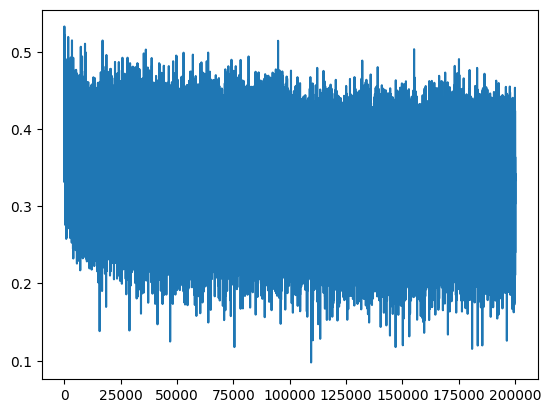

In [19]:
plt.plot(lossi)

In [20]:
# calibrate the batch norm at the end of training
#with torch.no_grad():
    # pass the training set through
#    emb = C[Xtr]
#    embcat = emb.view(emb.shape[0], -1)
#    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
#    bnmean = hpreact.mean(0, keepdim=True)
#    bnstd = hpreact.std(0, keepdim=True)

In [21]:
#bnmean

In [22]:
#bnmean_running

In [23]:
@torch.no_grad() # this decorator disbles gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


In [24]:
# sample from the model 
#g = torch.Generator().manual_seed(2147483647 + 10)

#for _ in range(20):
#    out = []
#    context = [0] * block_size # init all with . * block_size
#    while True:
#        # forward pass the nn
#        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
#        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
#        logits = h @ W2 + b2
#        probs = F.softmax(logits, dim=1)
#        # sample from distribution
#        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
#        # shift the context window and track the samples
#        context = context[1:] + [ix]
#        out.append(ix)
#        # if we sample the special ".", break
#        if ix == 0:
#            break
#    print(''.join(itos[i] for i in out)) # decode and print the generated word

In [25]:
# PYTORCHIFY THE CODE

In [26]:
# Let's train a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # .out is not used in pytorch it is used here for gathering statistics to print in a graph below
        # update the buffers
        if self.training:
            with torch.no_grad(): # no_grad() tells pytorch whatever is inside will not have .backwards() called on it so pytorch doesn't need to keep track of the gradient
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dim of the char embedding vectors
n_hidden = 100 # num of neurons in hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # if last layer is batchnorm its .gamma instead of .weight because in the batchnorm class its gamma and not weight
    # for all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # num of params in total
for p in parameters:
    p.requires_grad = True

47024


In [27]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    #forward pass
    emb = C[Xb] # embed the char into the vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss func

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after debug: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # after debug remove

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

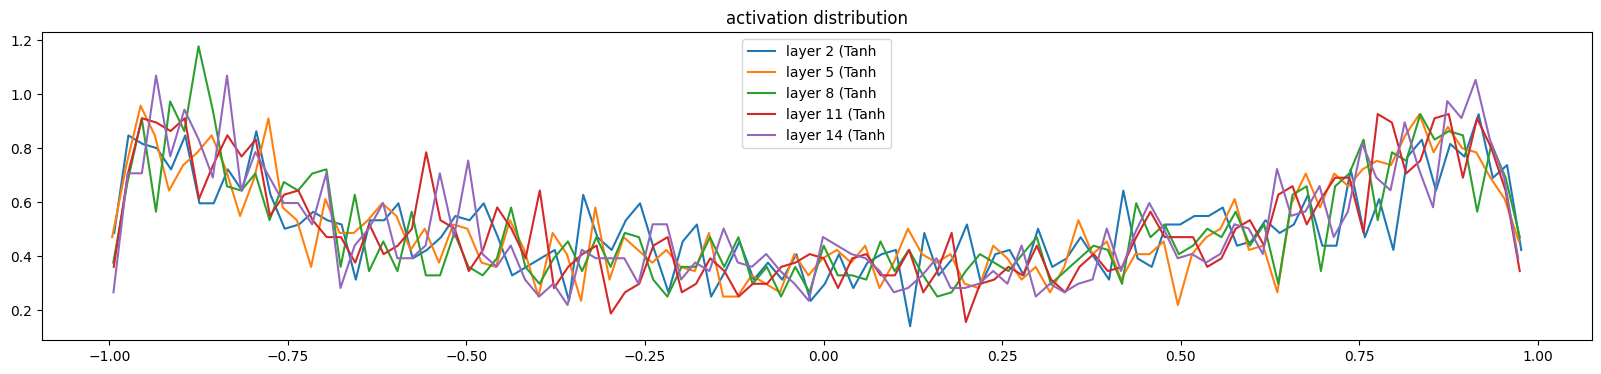

In [28]:
# visualize histogram
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.00, std 3.682959e-03
layer 5 (      Tanh): mean -0.00, std 3.262612e-03
layer 8 (      Tanh): mean -0.00, std 2.973733e-03
layer 11 (      Tanh): mean +0.00, std 2.741114e-03
layer 14 (      Tanh): mean +0.00, std 2.584295e-03


Text(0.5, 1.0, 'activation distribution')

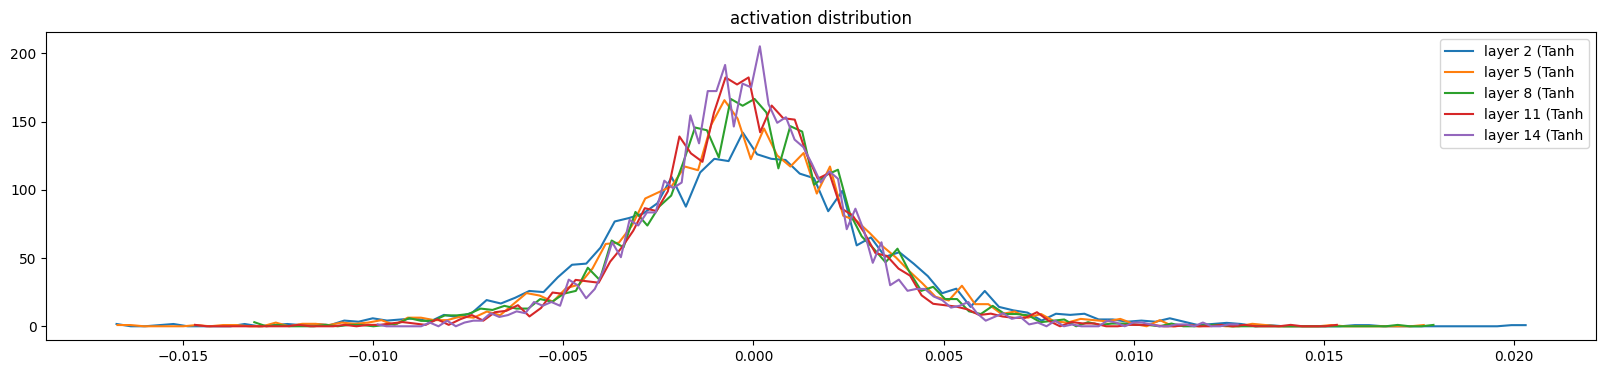

In [29]:
# visualize histogram
plt.figure(figsize=(20, 4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title("activation distribution")

weight   (27, 10) | mean +0.000000 | std 1.019889e-02 | grad:data ratio 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238441e-03 | grad:data ratio 2.635843e-02
weight (100, 100) | mean +0.000031 | std 7.318123e-03 | grad:data ratio 4.377151e-02
weight (100, 100) | mean -0.000019 | std 6.662030e-03 | grad:data ratio 3.949899e-02
weight (100, 100) | mean -0.000019 | std 5.821520e-03 | grad:data ratio 3.468163e-02
weight (100, 100) | mean +0.000053 | std 5.445301e-03 | grad:data ratio 3.243370e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281271e-02


Text(0.5, 1.0, 'Weights gradient distribution')

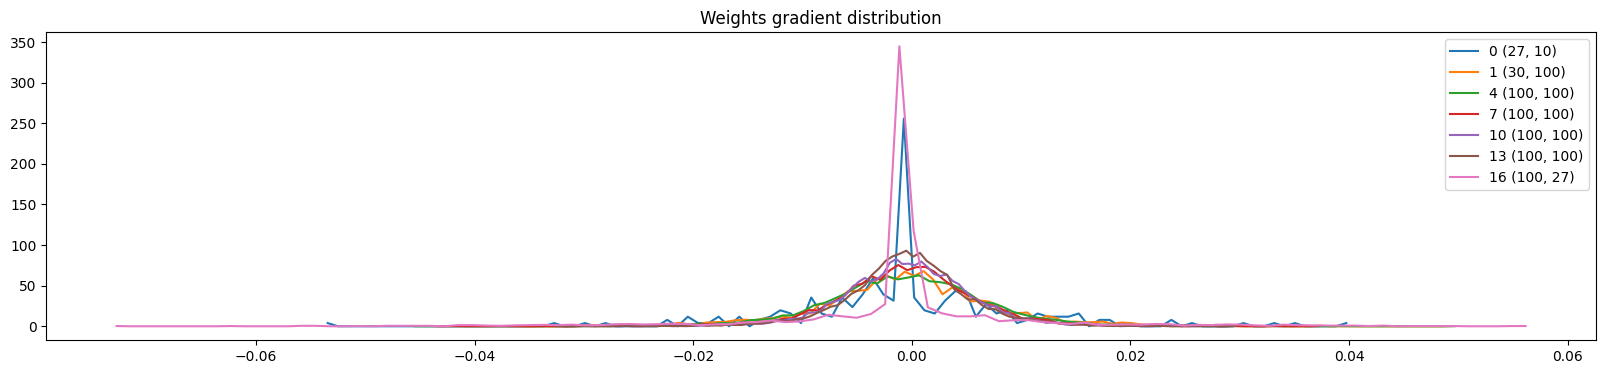

In [30]:
# visual histo
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights gradient distribution')

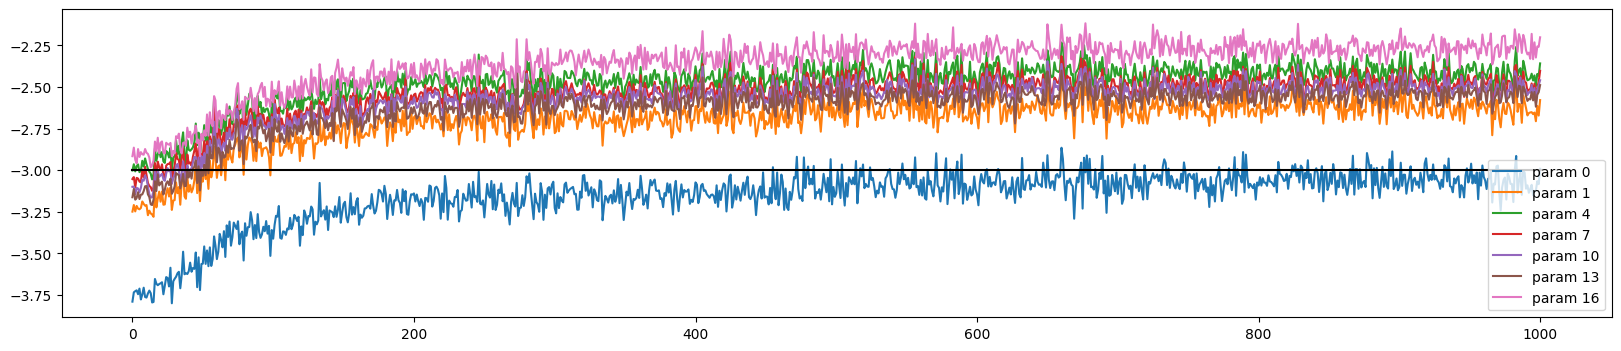

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);